<div align="center">

# Уменьшение размерности без учителя с помощью метода главных компонент

</div>

---

**Извлечение признаков (feature extraction)** путём уменьшения размерности, поможет сделать наполнение набора данных более обобщенным, преобразовав его в новое подпространство объектов более низкой размерности, чем исходное.


---

## 1. Отбор признаков vs. извлечение признаков

* **Отбор признаков (Feature Selection)**

  * Сохраняем *исходные* признаки.
  * Примеры:

    * Последовательный прямой/обратный отбор (SFS/SBS).
    * Методы на основе важности (e.g. дерево решений, LASSO).
      
  * Цель: убрать «лишние» признаки без их трансформации.

* **Извлечение признаков (Feature Extraction)**

  * Преобразуем исходные признаки в новые, часто с меньшей размерностью.
  * Цель: сжать данные, сохранив максимальную информативность.
  * Выгоды:

    * Снижение вычислительных затрат и требования к памяти.
    * Борьба с «проклятием размерности» → разгрузка нерегуляризованных моделей.

---

## 2. Principal Component Analysis (PCA)

> **PCA** — метод *линейного*, *обучения без учителя* для извлечения признаков и уменьшения размерности.

### 2.1 Применения PCA

* Исследовательский анализ данных (EDA).
* Шумоподавление (например, в финансовых сигналах).
* Биoинформатика (анализ экспрессии генов, геномные данные).

### 2.2 Основная идея

1. **Ищем направления максимальной дисперсии** в многомерных данных.
2. **Проецируем** данные на новое пространство измерений (≤ исходного).
3. **Главные компоненты** (PCs) — ортогональны друг другу и упорядочены по убыванию дисперсии.

> Даже при коррелированных исходных признаках результат будет *некоррелированным* (ортогональным).

---

## 3. Математическая формулировка

Пусть

$$
\mathbf{x} = [x_1, x_2, \dots, x_d]^\top \in \mathbb{R}^d
$$

— вектор признаков, и

$$
W \in \mathbb{R}^{d \times k}
$$

— матрица преобразования (проекции) с $k$ столбцами (PCs).
Тогда

$$
\mathbf{z} = W^\top \mathbf{x}, \quad \mathbf{z} \in \mathbb{R}^k,
$$

где $k \ll d$.

* Первый столбец $w_1$ → направление с *максимальной* дисперсией.
* Последующие $w_j$ выбираются так, чтобы оставаться ортогональными к предыдущим и максимизировать остаточную дисперсию.

> **Важно**: перед PCA обязательно **стандартизировать** признаки (нулевое среднее, единичная дисперсия), если они в разных масштабах.

---

## 4. Алгоритм PCA — по шагам

1. **Стандартизация**
   $\displaystyle \tilde{x}_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}$.

2. **Построение ковариационной матрицы**

   $$
   C = \frac{1}{n-1} \tilde{X}^\top \tilde{X}, \quad C \in \mathbb{R}^{d \times d}.
   $$

3. **Собственное разложение**

   $$
   C \, v_i = \lambda_i \, v_i,
   $$

   где $\lambda_i$ — собственное значение, $v_i$ — соответствующий собственный вектор.

4. **Сортировка**
   Упорядочить $\{\lambda_i\}$ по убыванию:
   $\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_d$.

5. **Выбор главных компонентов**
   Выбрать $k$ векторов $v_1, \dots, v_k$, соответствующих $k$ наибольшим $\lambda$.

6. **Формирование матрицы проекции**

   $$
   W = [\,v_1 \;\; v_2 \;\; \dots \;\; v_k\,] \in \mathbb{R}^{d \times k}.
   $$

7. **Преобразование данных**

   $$
   Z = \tilde{X} \, W \quad (\;Z\in \mathbb{R}^{n \times k}\;).
   $$

---

### В следующих шагах

* **Реализация PCA «с нуля» на Python**: вычисление ковариации, собственных значений/векторов, проекция.
* **Использование scikit-learn**: класс `PCA` для быстрой и удобной работы.

---

Далее мы рассмотрим первые четыре шага алгоритма РСА:
1. Стандартизация данных.
2. Построение ковариационной матрицы.
3. Получение собственных значений и собственных векторов ковариационной мат­
рицы.
4. Сортировка собственных значений по убыванию для ранжирования собственных
векторов.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

In [106]:
# Загрузка датасета Wine из репозитория UCI в DataFrame без заголовков
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/'
                      'wine/wine.data', header=None)

# Назначение имен столбцам для лучшей читаемости и удобства
df_wine.columns = ['Class label',        # Класс вина (1, 2 или 3)
                   'Alcohol',            # Содержание алкоголя
                   'Malic acid',         # Яблочная кислота
                   'Ash',                # Зольность
                   'Alcalinity of ash',  # Щелочность золы
                   'Magnesium',          # Магний
                   'Total phenols',      # Общее количество фенолов
                   'Flavanoids',         # Флавоноиды
                   'Nonflavanoid phenols',       # Нефлавоноидные фенолы
                   'Proanthocyanins',             # Проантоцианы
                   'Color intensity',             # Интенсивность цвета
                   'Hue',                         # Оттенок
                   'OD280/OD315 of diluted wines',# Показатель OD280/OD315
                   'Proline']   

In [107]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3,
                     stratify = y,
                     random_state = 0)
# 1) Провести стандартизацию
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

## 🧮 Шаг 2: Построение ковариационной матрицы

После стандартизации данных мы переходим ко **второму шагу PCA** — созданию **ковариационной матрицы**.

### Что это такое?

* **Ковариационная матрица** — квадратная матрица размером $d \times d$, где $d$ — число признаков.
* Она показывает, **как признаки изменяются вместе**:

  * Положительная ковариация → признаки растут или падают **вместе**.
  * Отрицательная ковариация → один признак растёт, другой падает.
* Пример (3 признака):

$$
C = 
\begin{bmatrix}
\sigma_{11} & \sigma_{12} & \sigma_{13} \\
\sigma_{21} & \sigma_{22} & \sigma_{23} \\
\sigma_{31} & \sigma_{32} & \sigma_{33} \\
\end{bmatrix}
$$

*Все значения на главной диагонали — дисперсии, остальные — попарные ковариации.*

---

## 🧠 Шаг 3: Собственные значения и векторы

* **Собственные векторы** ковариационной матрицы — это и есть **главные компоненты (PCs)**.
* **Собственные значения** показывают, **насколько важна** каждая компонента (т.е. сколько дисперсии она объясняет).

Формула:

$$
C \cdot v = \lambda \cdot v
$$

где:

* $C$ — ковариационная матрица,
* $v$ — собственный вектор (направление),
* $\lambda$ — собственное значение (величина дисперсии вдоль этого направления).

---



In [108]:
# 2) Построить ковариционную матрицу
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


Применив функцию `numpy.cov`, мы вычислили ковариационную матрицу стандартизированного набора обучающих данных. А используя функцию `linalg.eig`, мы выполнили собственное разложение, в результате чего был получен вектор **(eigen_vals)**, состоящий из 13 собственных значений и соответствующих собственных векторов, хранящихся в виде столбцов в матрице 13 х 13 **(eigen_vecs)**.

---


##  Шаг 4: Выбор главных компонент (уменьшение размерности)

После получения всех собственных значений и векторов, мы **не используем их все** — ведь наша цель — **уменьшить размерность** и сохранить при этом **максимум релевантной информации**.

### Что делаем?

1. **Сортируем собственные значения** по убыванию.

   * Чем **больше** собственное значение — тем **больше дисперсии** объясняет соответствующая компонента.
2. **Выбираем только первые $k$** главных компонент (с наибольшими собственными значениями).

   * Это и будет наше **новое подпространство признаков**.

---

## Объяснённая дисперсия

Чтобы понять, сколько информации сохраняет каждая компонента, рассчитываем **долю объяснённой дисперсии**:

$$
\text{Explained variance ratio}_j = \frac{\lambda_j}{\sum_{i=1}^{d} \lambda_i}
$$

где:

* $\lambda_j$ — собственное значение $j$-ой компоненты,
* $d$ — общее число компонент.

---


In [109]:
# Шаг 4 (сортировка) и выбор главных компонент
# С помощью функции 'cunsum' - можно вычислить накопительную
# сумму объясненных дисперсий
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

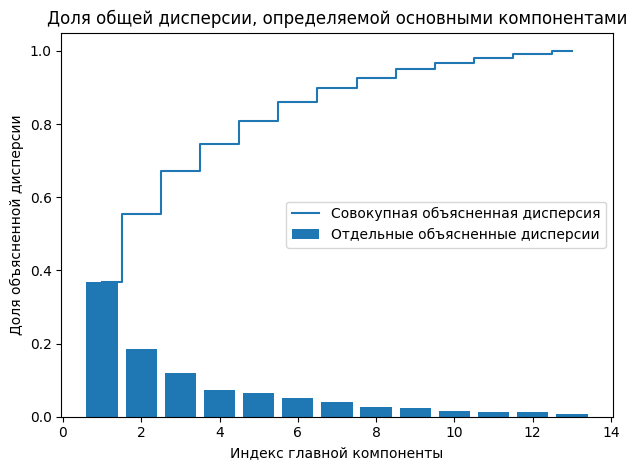

In [110]:
# Построение графика
plt.bar(range(1, 14), var_exp, align = 'center',
        label = 'Отдельные объясненные дисперсии')
plt.step(range(1, 14), cum_var_exp, where = 'mid',
         label = 'Совокупная объясненная дисперсия')
plt.ylabel('Доля объясненной дисперсии')
plt.xlabel('Индекс главной компоненты')
plt.title('Доля общей дисперсии, определяемой основными компонентами')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

Как показывает график, только на первую главную компоненту приходится примерно **40%** дисперсии. Кроме того, видно, что первые две компоненты объясняют почти **60%** дисперсии в наборе данных Wine.

Хотя график объяснённой дисперсии может напоминать важность признаков, **PCA — это метод без учителя**.
Он **не учитывает метки классов**, а просто ищет направления максимального разброса данных (дисперсии).

В отличие от этого, **случайный лес** использует метки классов и оценивает важность признаков по тому, насколько они помогают разделять классы.

**Итог**:
PCA — про **структуру данных**,
Случайный лес — про **разделение классов**.

---

## Финальные шаги PCA: Проекция данных

После того как мы получили собственные значения и векторы, осталось выполнить **последние 3 шага**, чтобы получить данные в новом пространстве главных компонент.

###  Что нужно сделать?

5. **Выбрать `k` главных компонент**
   — т.е. взять `k` собственных векторов, соответствующих наибольшим собственным значениям.

6. **Построить матрицу проекции `W`**
   — из этих `k` собственных векторов (размерность будет `d × k`, где `d` — число признаков).

7. **Преобразовать исходные данные `X`**
   — умножаем матрицу признаков `X` на `W`, чтобы получить новые признаки меньшей размерности:

$$
X' = X \cdot W
$$

---

###  Пример: Набор данных Wine

* У Wine 13 признаков, поэтому ковариационная матрица — $13 \times 13$.
* Мы выберем **2 главные компоненты**, которые объясняют \~60% дисперсии (для визуализации).
* Получим матрицу проекции $W \in \mathbb{R}^{13 \times 2}$.

Теперь можно:

* **Преобразовать один пример**:

  $$
  \mathbf{x'} = \mathbf{x} \cdot W
  $$

  где $\mathbf{x}$ — строка из 13 признаков, а $\mathbf{x'}$ — строка из 2 новых признаков.

* **Преобразовать весь набор** (124 примера):

  $$
  X' = X \cdot W, \quad X' \in \mathbb{R}^{124 \times 2}
  $$

---

### Замечание

В этом примере выбрано только **2 компоненты** для удобства отображения на 2D-графике.
На практике количество `k` зависит от:

* того, сколько **информации (дисперсии)** вы хотите сохранить;
* компромисса между **вычислительной эффективностью** и **производительностью классификатора**

In [111]:
# Сортировка собственных пар по убыванию собственных значений

# Создаем список пар
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]
#Сортируем пары по убыванию
eigen_pairs.sort(key=lambda k: k[0], reverse = True)

In [112]:
# Шаги 5-6
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Матрица W:\n', w)

Матрица W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [113]:
# Шаг 7
X_train_pca = X_train_std.dot(w)
print(X_train_pca)

[[ 2.38299011  0.45458499]
 [-1.96578183  1.65376939]
 [-2.53907598  1.02909066]
 [-1.43010776  0.6024011 ]
 [ 3.14147227  0.66214979]
 [ 0.50253552 -2.08907131]
 [ 0.04867722 -2.27536044]
 [ 2.47888989 -0.08603318]
 [ 2.01900259 -1.3538719 ]
 [ 0.75156583 -2.55367947]
 [ 0.72268915 -1.18404391]
 [-3.00366211  0.94626934]
 [ 2.57518878 -1.0697549 ]
 [ 3.73151104  1.01968876]
 [-1.12276518  0.13877   ]
 [ 2.85996853  2.28819559]
 [-0.74717125 -3.21746061]
 [-1.58427878  0.16048055]
 [ 3.38887101  2.11550689]
 [ 3.15405473  0.54233966]
 [-1.28036506 -1.72926871]
 [-1.71438911  0.71745249]
 [-1.55040291 -1.7580591 ]
 [ 1.10984489 -1.20480693]
 [-0.69108418 -1.71385374]
 [-2.086036   -1.68453671]
 [ 2.90393456  1.95258805]
 [-2.07635784  1.47183304]
 [-1.74756185 -1.25842546]
 [ 2.59424456 -0.1056037 ]
 [-2.50372355  0.70412212]
 [-2.19448402  2.18657552]
 [ 3.91634534  0.16136475]
 [-1.11739618  0.51921086]
 [-0.89996804 -2.04759575]
 [-1.71469178  0.61392169]
 [-2.48581303  0.76839561]
 

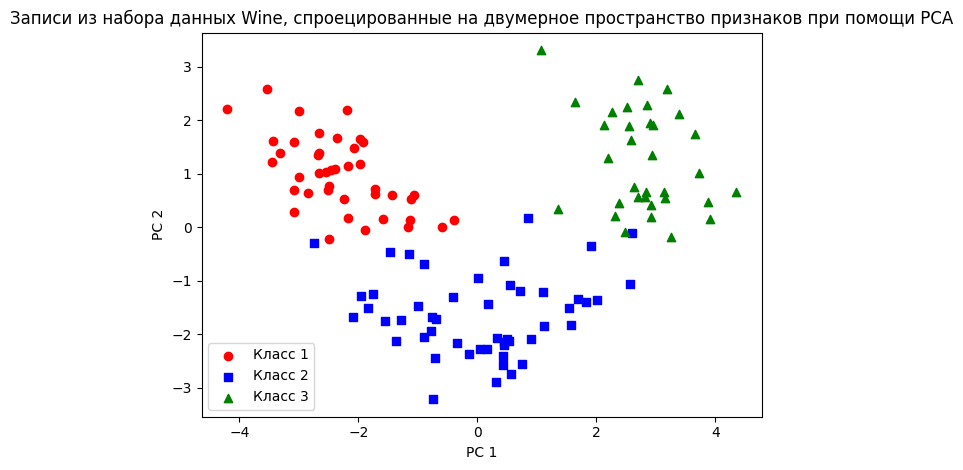

In [114]:
# Визуализация преобразованного обучающего набора Wine
# который теперь хранится в двумерной матрице 124x2

# Двумерная диаграмма рассеяния:
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
                X_train_pca[y_train == l, 1],
                c=c, label = f'Класс {l}', marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Записи из набора данных Wine, спроецированные на двумерное пространство признаков при помощи PCA')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show()

## Что показывает график:

* На графике изображены **проекции объектов из набора данных Wine** на **две главные компоненты** — `PC1` и `PC2`.
* Каждая точка — это один образец (вино), отображённый в новом пространстве признаков.

---

## Что можно заметить:

* **Хорошая разделимость** между классами:

  * Класс 1 отделён от остальных по оси `PC1`.
  * Класс 3 явно отделяется по `PC2`.
* PCA позволил **сжать 13 признаков** в **2 информативных**, сохранив при этом **основную структуру данных**.
* Это подтверждает, что PCA не только уменьшает размерность, но и **сохраняет полезные различия между классами**, что может помочь моделям классификации.

---

## Вывод по графику:

PCA эффективно свёл многомерные данные к 2D, при этом:

* Классы хорошо визуально разделяются;
* Сохранилась структура, необходимая для анализа и построения моделей;
* График наглядно показывает, **как полезно использовать PCA для предварительного анализа и визуализации данных**.

---

## Реализация PCA в scikit-learn

Применим класс **PCA** из **scikit-learn** к обучающему набору данных Wine, классифицируем преобразованные примеры с помощью логистической регресиии и затем визуализируем области принятия решений.

In [115]:
# График визуализации областей принятия решений
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Настройка генератора меток и цветной карты
    markers = ('o', 's', '^', 'v', '<')
    colors  = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap    = ListedColormap(colors[:len(np.unique(y))])

    # Построение решающей поверхности
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )
    Z = classifier.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Отрисовка всех образцов
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f'Класс {cl}',
            edgecolor='black'
        )

    # Подсветка тестовых образцов, если переданы индексы
    if test_idx is not None:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(
            X_test[:, 0], X_test[:, 1],
            facecolors='none',
            edgecolors='black',
            alpha=1.0,
            linewidth=1,
            marker='o',
            s=100,
            label='Тестовый набор'
        )

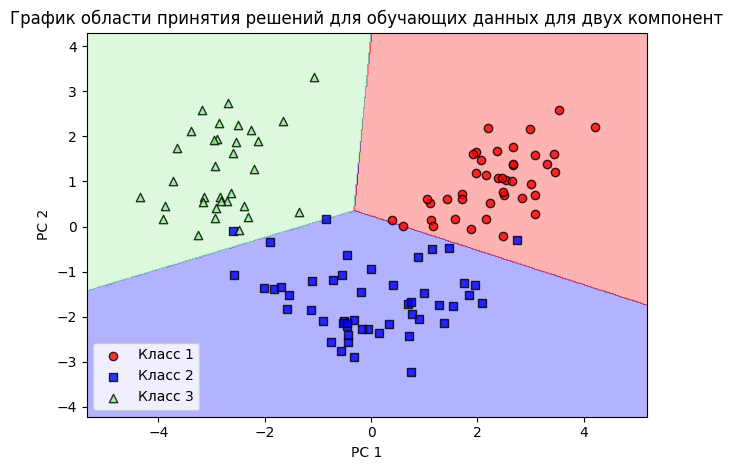

In [116]:
# инициализация преобразователя PCA
# и оценивателя логистической регресии
pca = PCA(n_components = 2)
lr = OneVsRestClassifier(LogisticRegression(random_state = 1,
                                            solver = 'lbfgs'))

# Понижение размерности
X_train_pca_1 = pca.fit_transform(X_train_std)
X_test_pca_1 = pca.fit_transform(X_test_std)

# Обучение модели Логистической регрессии на новом наборе
lr.fit(X_train_pca_1, y_train)

#Построение графика областей принятия решений
plot_decision_regions(X_train_pca_1, y_train, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('График области принятия решений для обучающих данных для двух компонент')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show()

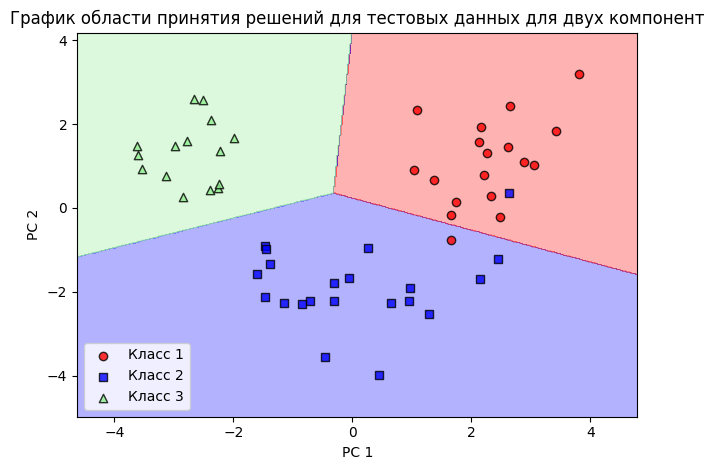

In [117]:
# Применим тоже самое для тестовых данных
plot_decision_regions(X_test_pca_1, y_test, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('График области принятия решений для тестовых данных для двух компонент')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show()

#### Зеркальное отображение графиков PCA

Если вы сравните результат **своей реализации PCA** и реализации из **scikit-learn**, то можете заметить, что:

> **Графики выглядят как зеркальные отражения друг друга.**

#### Почему так происходит?

* Это **не ошибка**.
* **Собственные векторы могут быть направлены в любую сторону** — их знак (положительный или отрицательный) не влияет на результат.
* Разные библиотеки могут по-разному выбирать знак векторов.
* Если нужно, вы можете "зеркально отразить" результат, просто умножив данные на $-1$.

> Примечание: Собственные векторы обычно нормализуются до длины 1 (единичные векторы).

---

#### Оценка качества модели после PCA

После снижения размерности до 2-х признаков, вы можете, например, обучить **логистическую регрессию** и проверить, как она работает на этих новых данных.

Как правило, она показывает хорошее качество и делает **лишь несколько ошибок на тесте**, несмотря на уменьшенное количество признаков.

---

#### Получение объяснённой дисперсии в scikit-learn

Если вы хотите посмотреть, сколько дисперсии объясняет каждая главная компонента:

1. Установите `n_components=None`, чтобы сохранить **все** компоненты.

2. Получите долю объяснённой дисперсии через `explained_variance_ratio_`.

Это даст вам массив, где каждый элемент — доля информации (дисперсии), объяснённой соответствующей компонентой.

---

In [118]:
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

Можно обратить внимание, что при инициализации класса **PCA**, параметр `n_components = None`, это чтобы класс возвращал все главные компоненты в отсортированном порядке - вместо выполнения уменьшения размерности.

---

## Как оценить вклад признаков в главные компоненты (нагрузки)

Когда мы применяем PCA, каждая **главная компонента** — это **линейная комбинация исходных признаков**.

>  Иногда полезно понять, **какие признаки сильнее всего влияют на конкретную компоненту**.

### Что такое нагрузка (loading)?

* **Нагрузка признака** показывает, насколько сильно он влияет на определённую компоненту.
* Это помогает интерпретировать компоненты и понять, какие признаки «ведущие».

---

## Как рассчитать нагрузки

Нагрузки можно найти так:

$$
\text{loading} = v \cdot \sqrt{\lambda}
$$

где:

* $v$ — собственный вектор (направление компоненты),
* $\lambda$ — соответствующее собственное значение (дисперсия по компоненте).

> Результат можно интерпретировать как **корреляцию** между признаком и главной компонентой.

---

###  Для чего это нужно?

* Выяснить, какие признаки «влияют» на каждую компоненту.
* Упростить интерпретацию PCA (например, для визуализации или отчёта).
* Отделить информативные признаки от шумовых.

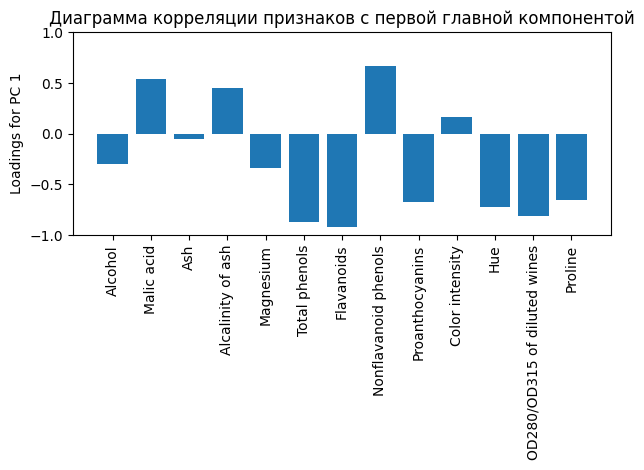

In [119]:
# Построим диаграмму нагрузок для первой главной компоненты

# Вычислить матрицу нагрузок 13 x 13 умножая собственный вектор на квадратный
# корень из собственных значений
loadings = eigen_vecs * np.sqrt(eigen_vals)

# Диаграмма нагрузки для первой компоненты
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 0], align = 'center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation = 90)
plt.title('Диаграмма корреляции признаков с первой главной компонентой')
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

Как мы видим на рисунке `алкоголь (Alcohol)` имеет отрицательную корреляцию с первой главной компонентой **(-0.3 примерно)**, тогда как `яблочная кислота (Malic acid)` имеет положительную корреляцию **(0.54 примерно)**. Значение 1 описывает идеальную положительную корреляцию, тогда как значение -1 соответствует идеальной отрицательной корреляции.

---

Аналогично нашей реализации PCA факторной нагрузки, можем получить нагрузки из обученного объекта PCA `scikit-learn` , где **pca.components_** представляет собственные векторы, а **pca.explained_variance_** представляет собственные значения.

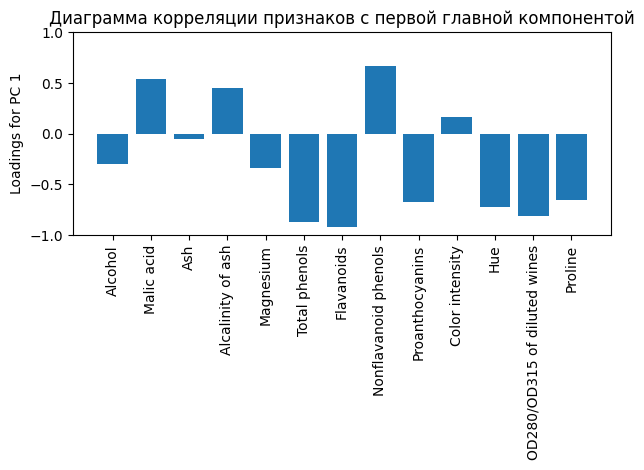

In [120]:
# Факторные нагрузки 
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Строим диаграмму
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 0], align = 'center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation = 90)
plt.title('Диаграмма корреляции признаков с первой главной компонентой')
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

>Эта диаграмма идентична той, что была в ручной реализации.